In [66]:
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error, root_mean_squared_error
from scipy import sparse as sp

In [67]:
class MLDataset:
    def __init__(self, movies, ratings):
        self.movies = movies.copy()
        self.ratings = ratings.copy()
        self.m2m_new = {idx: i for i, idx in enumerate(ratings['movieId'].unique())}
        self.u2u_new = {idx: i for i, idx in enumerate(ratings['userId'].unique())}

    def convert(self):
        self.movies['movieId'] = self.movies['movieId'].apply(lambda x: self.m2m_new.get(x, -1))
        self.movies['movieId'] = self.movies['movieId'].astype(int)
        self.ratings['userId'] = self.ratings['userId'].map(self.u2u_new)
        self.ratings['movieId'] = self.ratings['movieId'].map(self.m2m_new)

        reviews_dict = self.ratings.groupby('userId').apply(lambda x: dict(zip(x['movieId'], x['rating']))).to_dict()
        m2title = {m_id: title for m_id, title in zip(self.movies['movieId'].values, self.movies['title'].values)}
        title2m = {title:m_id for m_id, title in zip(self.movies['movieId'].values, self.movies['title'].values)}
        return self.movies, reviews_dict, self.ratings, m2title, title2m
    
    def train_test_split(self, num_test_samples=10):
        train_ratings, test_ratings = [], []
        for userId, user_data in self.ratings.groupby('userId'):
            n_samples = len(user_data)
            if n_samples < 2*num_test_samples:
                train_ratings += user_data
            else:
                train_ratings += [user_data[:-num_test_samples]]
                test_ratings += [user_data[-num_test_samples:]]
        train_ratings = pd.concat(train_ratings)
        test_ratings = pd.concat(test_ratings)
        return train_ratings, test_ratings


In [68]:
movies_original = pd.read_csv('datasets/ml-latest-small/movies.csv')
ratings_original = pd.read_csv('datasets/ml-latest-small/ratings.csv')

ml_dataset = MLDataset(movies_original, ratings_original)

movies_original, ratings_dict, ratings_original, m2title, title2m = ml_dataset.convert()

train_ratings, test_ratings = ml_dataset.train_test_split()

print(train_ratings.shape, test_ratings.shape)

(94736, 4) (6100, 4)


In [34]:
train_ratings.head()

,userId,movieId,rating,timestamp
0,0,0,4.0,964982703
1,0,1,4.0,964981247
2,0,2,4.0,964982224
3,0,3,5.0,964983815
4,0,4,5.0,964982931


In [69]:
print(train_ratings['movieId'].max(), len(train_ratings['movieId'].unique()))
print(ratings_original['movieId'].max(), len(ratings_original['movieId'].unique()))

9721 9361
9723 9724


In [197]:
class ALSRecSys:
    def __init__(self, num_users, num_items, m2title, num_dims=30):
        self.num_dims = num_dims
        self.num_users = num_users
        self.num_items = num_items
        self.m2title = m2title
        self.title2m = {title: movie_id for movie_id, title in self.m2title.items()}
        self.train_ratings = None
        self.test_ratings = None
        self.R = None
        self.history = {'train_rmse': [], 'test_rmse': []}
        self.X = None
        self.Y = None
    
    def _reset(self):
        self.train_ratings = None
        self.test_ratings = None
        self.R = None
        self.history = {'train_rmse': [], 'test_rmse': []}
        self.X = None
        self.Y = None

    def fit(self, train_ratings, test_ratings, num_iters=10, eps=1):
        self._reset()
        self.train_ratings = train_ratings.copy()
        self.test_ratings = test_ratings.copy()
        self.m2title = m2title
        self.R = self._get_R(self.train_ratings)
        self.history = []
        X, Y = self._ALS_fit(num_iters, eps)
        self.X = X
        self.Y = Y
    
    def _get_R(self, reviews):
        # Example: Create a COO matrix from the 'ratings' DataFrame
        users = reviews['userId'].values
        items = reviews['movieId'].values
        values = reviews['rating'].values

        num_users = self.num_users
        num_items = self.num_items
        # Create a sparse matrix in COO format
        R = sp.coo_array((values, (users, items)), shape=(num_users, num_items)).tocsr()
        #R = sp.coo_matrix((values, (users, movies))).tocsr()
        return R

    def _ALS_fit(self, num_iters, eps):
        R = self.R
        num_dims = self.num_dims
        num_users = self.num_users
        num_items = self.num_items
        X = np.random.randn(num_users, num_dims) #Users
        Y = np.random.randn(num_items, num_dims) #Items
        
        for t in range(num_iters):
            RY = R @ Y
            for u in range(num_users):
                relevant_items = self.train_ratings[self.train_ratings['userId'] == u]['movieId'].values
                Y_rel = Y[relevant_items]
                YY = Y_rel.reshape(-1, num_dims, 1) * Y_rel.reshape(-1, 1, num_dims)
                X[u] = np.linalg.inv(YY.sum(axis=0) + eps * np.eye(num_dims)) @ RY[u]

            RX = R.T @ X
            for i in range(num_items):
                relevant_users = self.train_ratings[self.train_ratings['movieId'] == i]['userId'].values
                X_rel = X[relevant_users]
                XX = X_rel.reshape(-1, num_dims, 1) * X_rel.reshape(-1, 1, num_dims)
                Y[i] = np.linalg.inv(XX.sum(axis=0) + eps * np.eye(num_dims)) @ RX[i]
            train_rmse, test_rmse = self._get_rmse(X, Y)
            print(f"Iter: {t:>3} TRAIN RMSE: {train_rmse:5.3f} TEST RMSE: {test_rmse:5.3f}")
        return X, Y
    
    def _get_rmse(self, X, Y):
        train_preds = (X[self.train_ratings.userId] * Y[self.train_ratings.movieId]).sum(axis=1)
        test_preds = (X[self.test_ratings.userId] * Y[self.test_ratings.movieId]).sum(axis=1)
        train_preds = np.clip(train_preds, 0.5, 5)
        test_preds = np.clip(test_preds, 0.5, 5.0)
        train_rmse = root_mean_squared_error(train_preds, self.train_ratings['rating'])
        test_rmse = root_mean_squared_error(test_preds, self.test_ratings['rating'])
        return train_rmse, test_rmse

    def _get_rankings(self, user_id_mapped):
        rankings = self.Y @ self.X[user_id_mapped].T
        #rankings = self.X[user_id_mapped] @ self.Y.T
        return rankings
    
    def get_rankings(self, user_id):
        user_id_mapped = self.u2idx[user_id]
        rankings = self._get_rankings(user_id_mapped)
        rankings = [(self.idx2m[idx], score) for idx, score in enumerate(rankings)]
        rankings = sorted(rankings, key=lambda x: x[1], reverse=True)
        return rankings
    
    def recommend(self, user_id, top_k=10, not_seen=True):
        rankings = self._get_rankings(user_id)

        if not_seen:
            viewed_items = set(self.train_ratings[train_ratings['userId'] == user_id]['movieId'])
            rankings = [(idx, score) for idx, score in enumerate(rankings) if idx not in viewed_items]
        else:
            rankings = [(idx, score) for idx, score in enumerate(rankings)]

        # Get the top k items with the highest score
        top_k_recommendations = sorted(rankings, key=lambda x: x[1], reverse=True)[:top_k]
        return top_k_recommendations
    
    def print_recommend(self, user_id, top_k=10, not_seen=True):
        top_k_recommendations = self.recommend(user_id, top_k, not_seen)
        print(*list(map(lambda x: f"id: {x[0]: <10} {self.m2title[x[0]]: <80} score: {x[1]}", top_k_recommendations)), sep='\n')

    def most_similar(self, movie_title, top_k=10):
        movie_id = self.title2m.get(movie_title, None)
        if movie_id is None:
            print(f'{movie_title} not found!')
            return 0
        movie_vec = self.Y[movie_id]
        similarities = []
        for i in range(self.Y.shape[0]):
            if i != movie_id:
                nom = np.dot(movie_vec, self.Y[i])
                denom = np.linalg.norm(movie_vec)*np.linalg.norm(self.Y[i])
                if not denom:
                    similarities.append((i, 0))
                else:
                    sim = nom/denom
                    similarities.append((i, sim))
        top_k_similarities = sorted(similarities, key=lambda x: x[1], reverse=True)[:top_k]
        return top_k_similarities

    def print_most_similar(self, movie_title, top_k=10):
        top_k_most_similar = self.most_similar(movie_title, top_k=10)
        print(*list(map(lambda x: f"id: {x[0]: <10} {self.m2title[x[0]]: <80} score: {x[1]}", top_k_most_similar)), sep='\n')

In [198]:
num_items = len(ratings_original['movieId'].unique())
num_users = len(ratings_original['userId'].unique())
print(f'num_users: {num_users} num_items: {num_items}')
print()
als = ALSRecSys(num_users, num_items, m2title)
als.fit(train_ratings, test_ratings, num_iters=5, eps=1)


num_users: 610 num_items: 9724

Iter:   0 TRAIN RMSE: 1.632 TEST RMSE: 2.377
Iter:   1 TRAIN RMSE: 0.651 TEST RMSE: 1.782
Iter:   2 TRAIN RMSE: 0.480 TEST RMSE: 1.804
Iter:   3 TRAIN RMSE: 0.413 TEST RMSE: 1.832
Iter:   4 TRAIN RMSE: 0.376 TEST RMSE: 1.849


In [199]:
als.print_recommend(user_id=598, not_seen=False)

id: 722        Dr. Strangelove or: How I Learned to Stop Worrying and Love the Bomb (1964)      score: 5.450577488870256
id: 1094       Blade Runner (1982)                                                              score: 5.371637261081179
id: 75         Alien (1979)                                                                     score: 5.324088474113974
id: 108        Big Lebowski, The (1998)                                                         score: 5.257121332494494
id: 84         Groundhog Day (1993)                                                             score: 5.10616882201697
id: 1109       Manchurian Candidate, The (1962)                                                 score: 4.944543672976586
id: 1125       Amelie (Fabuleux destin d'Amélie Poulain, Le) (2001)                             score: 4.903371457442445
id: 723        2001: A Space Odyssey (1968)                                                     score: 4.883860340512179
id: 1138       Sting, The (1973) 

In [200]:
als.print_recommend(user_id=6)

id: 1133       Toy Story 3 (2010)                                                               score: 5.837965902110561
id: 332        Rear Window (1954)                                                               score: 5.346323254927514
id: 222        Blazing Saddles (1974)                                                           score: 5.282064592299535
id: 13         Dumb & Dumber (Dumb and Dumber) (1994)                                           score: 5.139204073655108
id: 530        Crimson Tide (1995)                                                              score: 4.9475918689007905
id: 1074       Captain America: The Winter Soldier (2014)                                       score: 4.939757258942987
id: 170        Mummy, The (1999)                                                                score: 4.888059366950731
id: 70         Raiders of the Lost Ark (Indiana Jones and the Raiders of the Lost Ark) (1981)   score: 4.772717253481783
id: 28         Schindler's List

In [201]:
als.print_most_similar('Star Wars: Episode IV - A New Hope (1977)', top_k=10)

id: 68         Star Wars: Episode V - The Empire Strikes Back (1980)                            score: 0.9876464175013507
id: 73         Star Wars: Episode VI - Return of the Jedi (1983)                                score: 0.9757310209044194
id: 70         Raiders of the Lost Ark (Indiana Jones and the Raiders of the Lost Ark) (1981)   score: 0.965941287073463
id: 89         Indiana Jones and the Last Crusade (1989)                                        score: 0.9651124703684777
id: 81         Terminator, The (1984)                                                           score: 0.9577256748188281
id: 25         Fugitive, The (1993)                                                             score: 0.9568671668910638
id: 117        Lethal Weapon (1987)                                                             score: 0.9558584803893001
id: 7          Braveheart (1995)                                                                score: 0.9545084218659008
id: 292        Twelve Mon

In [202]:
als.print_most_similar('Pulp Fiction (1994)', top_k=10)

id: 192        Fight Club (1999)                                                                score: 0.9766120261570349
id: 62         Reservoir Dogs (1992)                                                            score: 0.9750136133318134
id: 4          Usual Suspects, The (1995)                                                       score: 0.9695167197434075
id: 74         Goodfellas (1990)                                                                score: 0.9659636495251795
id: 353        Amadeus (1984)                                                                   score: 0.9597826328533221
id: 237        Departed, The (2006)                                                             score: 0.9582904221307115
id: 184        American Beauty (1999)                                                           score: 0.9556054205453388
id: 147        American History X (1998)                                                        score: 0.9544820776379206
id: 1027       Godfather

In [203]:
als.print_most_similar('Lord of the Rings: The Two Towers, The (2002)', top_k=10)

id: 753        Lord of the Rings: The Fellowship of the Ring, The (2001)                        score: 0.9938214756052117
id: 774        Lord of the Rings: The Return of the King, The (2003)                            score: 0.9935283465776582
id: 1254       Pirates of the Caribbean: Dead Man's Chest (2006)                                score: 0.937883416354588
id: 756        Spider-Man (2002)                                                                score: 0.9363358683970326
id: 794        Incredibles, The (2004)                                                          score: 0.9362417252108377
id: 1055       WALL·E (2008)                                                                    score: 0.9252346171842585
id: 238        Dark Knight, The (2008)                                                          score: 0.9235608821632175
id: 84         Groundhog Day (1993)                                                             score: 0.9231972116201346
id: 782        Spider-Man

In [204]:
als.print_most_similar("Godfather, The (1972)", top_k=10)

id: 1136       Godfather: Part II, The (1974)                                                   score: 0.9880919080895534
id: 74         Goodfellas (1990)                                                                score: 0.9705514872208869
id: 34         Silence of the Lambs, The (1991)                                                 score: 0.9700588541981945
id: 121        Saving Private Ryan (1998)                                                       score: 0.9662270690320399
id: 864        Graduate, The (1967)                                                             score: 0.9595128738151184
id: 76         Psycho (1960)                                                                    score: 0.9557509911996898
id: 353        Amadeus (1984)                                                                   score: 0.9555013985571533
id: 16         Pulp Fiction (1994)                                                              score: 0.9537654377234577
id: 1190       Scarface 

In [ ]:
def remove_train_items(preds, k):
    new_preds = np.zeros((preds.shape[0], k), dtype=np.int)
    for user_id, user_data in train_ratings.groupby('userId'):
        user_preds = preds[user_id]
        new_preds[user_id] = user_preds[~np.in1d(user_preds, user_data.movieId)][:k]
    
    return new_preds


def ALS_prediction(X, Y, k=10):
    preds = np.argsort(X @ Y.T, axis=1)
    return preds[:k]


def random_prediction(k=10):
    preds = np.tile(np.arange(num_movies), (num_users, 1))
    for i in range(num_users):
        rand_perm = np.random.permutation(num_movies)
        preds[i] = preds[i][rand_perm]

    return preds[:k]

def top_prediction(freq_thr=10, k=10):
    mean_rating = train_ratings.groupby('movieId').rating.mean()
    mean_rating = mean_rating[train_ratings.groupby('movieId').size() >= freq_thr]
    preds = np.array(mean_rating.sort_values(ascending=False).index)
    preds = np.tile(preds, (num_users, 1))
    return preds[:k]


def MAPk(y_true, y_pred, k=10):
    map_k, count = 0, 0
    for relevant_items, predicted_items in zip(y_true, y_pred):
        if not relevant_items:
            continue
        correct = np.isin(predicted_items[:k], relevant_items)
        map_k += (correct / np.arange(1, k + 1)).sum() / \
            (1 / np.arange(1, len(relevant_items) + 1)).sum()
        count += 1
    
    map_k = map_k / count
    return map_k

In [74]:
# Load data from disk
df = ratings_original.copy()
df.columns = ['user_id', 'item_id', 'rating', 'timestamp']
df.head()
n_users = df.user_id.unique().shape[0]
n_items = df.item_id.unique().shape[0]

# Create r_{ui}, our ratings matrix
ratings = np.zeros((n_users, n_items))
for row in df.itertuples():
    ratings[row[1], row[2]] = row[3]
print(ratings.shape)

def get_train_test(train_ratings, test_ratings):
    train = np.zeros((n_users, n_items))
    for row in train_ratings.itertuples():
        train[row[1], row[2]] = row[3]
    
    test = np.zeros((n_users, n_items))
    for row in test_ratings.itertuples():
        test[row[1], row[2]] = row[3]
    return train, test

train, test = get_train_test(train_ratings, test_ratings)
print(ratings.shape, train.shape, test.shape)

(610, 9724)
(610, 9724) (610, 9724) (610, 9724)


In [75]:
from sklearn.metrics import mean_squared_error

def get_mse(pred, actual):
    # Ignore nonzero terms.
    pred = pred[actual.nonzero()].flatten()
    actual = actual[actual.nonzero()].flatten()
    return mean_squared_error(pred, actual)

In [76]:
from numpy.linalg import solve

class ExplicitMF():
    def __init__(self, 
                 ratings, 
                 n_factors=40, 
                 item_reg=0.0, 
                 user_reg=0.0,
                 verbose=False):
        """
        Train a matrix factorization model to predict empty 
        entries in a matrix. The terminology assumes a 
        ratings matrix which is ~ user x item
        
        Params
        ======
        ratings : (ndarray)
            User x Item matrix with corresponding ratings
        
        n_factors : (int)
            Number of latent factors to use in matrix 
            factorization model
        
        item_reg : (float)
            Regularization term for item latent factors
        
        user_reg : (float)
            Regularization term for user latent factors
        
        verbose : (bool)
            Whether or not to printout training progress
        """
        
        self.ratings = ratings
        self.n_users, self.n_items = ratings.shape
        self.n_factors = n_factors
        self.item_reg = item_reg
        self.user_reg = user_reg
        self._v = verbose

    def als_step(self,
                 latent_vectors,
                 fixed_vecs,
                 ratings,
                 _lambda,
                 type='user'):
        """
        One of the two ALS steps. Solve for the latent vectors
        specified by type.
        """
        if type == 'user':
            # Precompute
            YTY = fixed_vecs.T.dot(fixed_vecs)
            lambdaI = np.eye(YTY.shape[0]) * _lambda

            for u in range(latent_vectors.shape[0]):
                latent_vectors[u, :] = solve((YTY + lambdaI), 
                                             ratings[u, :].dot(fixed_vecs))
        elif type == 'item':
            # Precompute
            XTX = fixed_vecs.T.dot(fixed_vecs)
            lambdaI = np.eye(XTX.shape[0]) * _lambda
            
            for i in range(latent_vectors.shape[0]):
                latent_vectors[i, :] = solve((XTX + lambdaI), 
                                             ratings[:, i].T.dot(fixed_vecs))
        return latent_vectors

    def train(self, n_iter=10):
        """ Train model for n_iter iterations from scratch."""
        # initialize latent vectors
        self.user_vecs = np.random.random((self.n_users, self.n_factors))
        self.item_vecs = np.random.random((self.n_items, self.n_factors))
        
        self.partial_train(n_iter)
    
    def partial_train(self, n_iter):
        """ 
        Train model for n_iter iterations. Can be 
        called multiple times for further training.
        """
        ctr = 1
        while ctr <= n_iter:
            if ctr % 10 == 0 and self._v:
                print('\tcurrent iteration: {}'.format(ctr))
            self.user_vecs = self.als_step(self.user_vecs, 
                                           self.item_vecs, 
                                           self.ratings, 
                                           self.user_reg, 
                                           type='user')
            self.item_vecs = self.als_step(self.item_vecs, 
                                           self.user_vecs, 
                                           self.ratings, 
                                           self.item_reg, 
                                           type='item')
            ctr += 1
    
    def predict_all(self):
        """ Predict ratings for every user and item. """
        predictions = np.zeros((self.user_vecs.shape[0], 
                                self.item_vecs.shape[0]))
        for u in range(self.user_vecs.shape[0]):
            for i in range(self.item_vecs.shape[0]):
                predictions[u, i] = self.predict(u, i)
                
        return predictions
    def predict(self, u, i):
        """ Single user and item prediction. """
        return self.user_vecs[u, :].dot(self.item_vecs[i, :].T)
    
    def calculate_learning_curve(self, iter_array, test):
        """
        Keep track of MSE as a function of training iterations.
        
        Params
        ======
        iter_array : (list)
            List of numbers of iterations to train for each step of 
            the learning curve. e.g. [1, 5, 10, 20]
        test : (2D ndarray)
            Testing dataset (assumed to be user x item).
        
        The function creates two new class attributes:
        
        train_mse : (list)
            Training data MSE values for each value of iter_array
        test_mse : (list)
            Test data MSE values for each value of iter_array
        """
        iter_array.sort()
        self.train_mse =[]
        self.test_mse = []
        iter_diff = 0
        for (i, n_iter) in enumerate(iter_array):
            if self._v:
                print('Iteration: {}'.format(n_iter))
            if i == 0:
                self.train(n_iter - iter_diff)
            else:
                self.partial_train(n_iter - iter_diff)

            predictions = self.predict_all()

            self.train_mse += [get_mse(predictions, self.ratings)]
            self.test_mse += [get_mse(predictions, test)]
            if self._v:
                print('Train mse: ' + str(self.train_mse[-1]))
                print('Test mse: ' + str(self.test_mse[-1]))
            iter_diff = n_iter

In [ ]:
%matplotlib inline
import matplotlib.pyplot as plt
#import seaborn as sns
#sns.set()

def plot_learning_curve(iter_array, model):
    plt.plot(iter_array, model.train_mse, \
             label='Training', linewidth=2)
    plt.plot(iter_array, model.test_mse, \
             label='Test', linewidth=2)


    plt.xticks(fontsize=16);
    plt.yticks(fontsize=16);
    plt.xlabel('iterations', fontsize=10);
    plt.ylabel('MSE', fontsize=10);
    plt.legend(loc='best', fontsize=20);

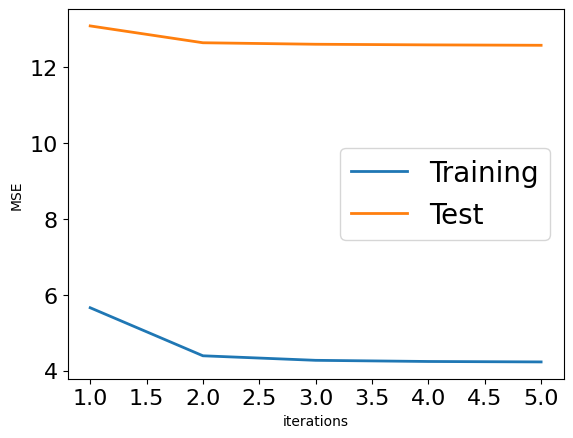

In [92]:
MF_ALS = ExplicitMF(train, n_factors=40, \
                    user_reg=0.0, item_reg=0.0)
iter_array = list(range(1, 6))
MF_ALS.calculate_learning_curve(iter_array, test)
plot_learning_curve(iter_array, MF_ALS)